# **Importing the libraries and raw data**

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
# Importing raw data
train_df = pd.read_csv("Training.csv")
test_df = pd.read_csv("Testing.csv")

# **Data Preparation**

In [ ]:
# Dropping NAs
train_df = train_df.dropna(axis=1, how='all')

In [ ]:
print(train_df.shape)
print(train_df.columns)

(4920, 133)
Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)


In [ ]:
print(test_df.shape)
print(test_df.columns)

(42, 133)
Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)


The original data contains 4920 rows in the training data, and 42 rows in the testing data, with 132 symptoms (features) in each dataframe. We now analyze the frequency of prognosis.

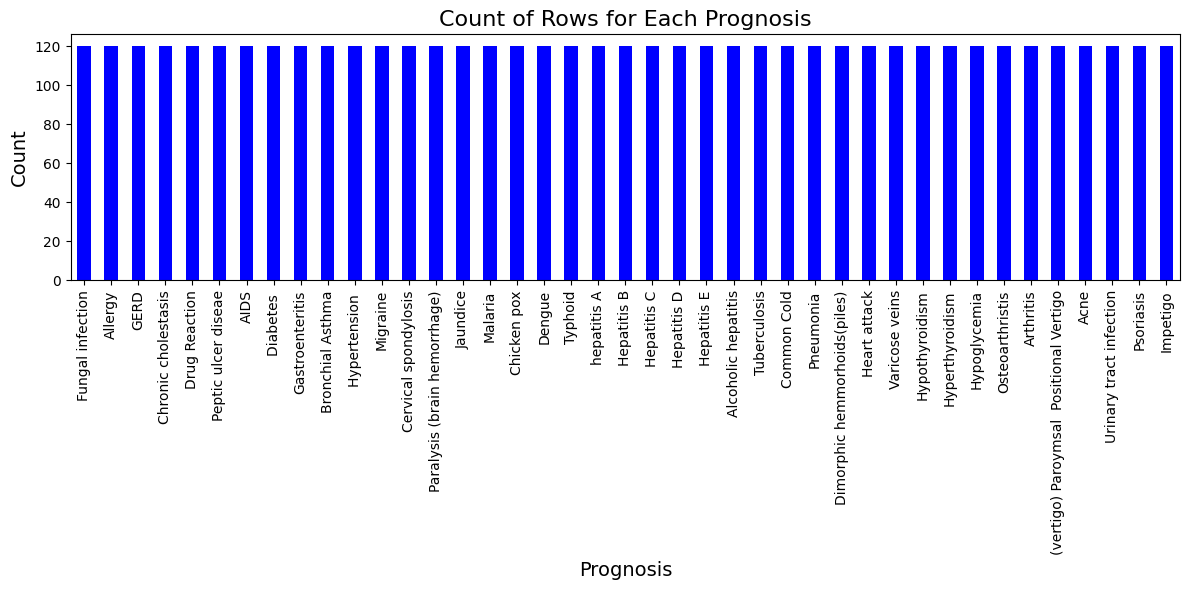

In [ ]:
# Number of rows for each prognosis in the training dataset
prognosis_count = train_df['prognosis'].value_counts()

plt.figure(figsize=(12,6))
prognosis_count.plot(kind='bar', color='blue')
plt.title('Count of Rows for Each Prognosis', fontsize=16)
plt.xlabel('Prognosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

There are exactly 120 rows for each prognosis. So essentially, there are 41 unique diseases in the training data (4920/120 = 41)

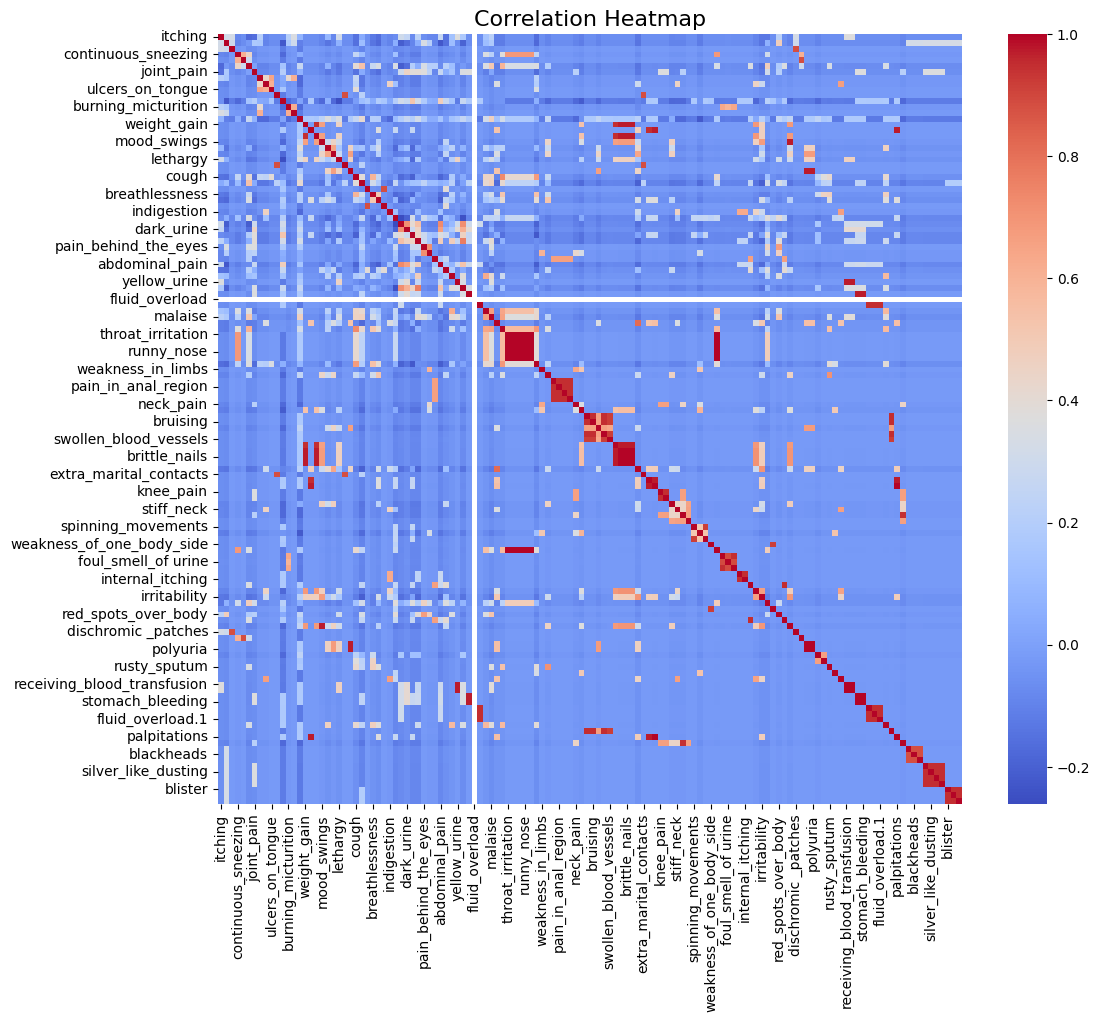

In [ ]:
# Correlation Matrix
numeric_data = train_df.select_dtypes(include=['int64','float64'])

correlation_matrix_disease = numeric_data.corr()

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix_disease, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

The rows in the testing data are 42, so each row is for 1 disease. This is a very small number, and ideally we would want more rows in the testing dataset to evaluate the model more effectively. To achieve that, we combine both the training and testing data, and split it in a ratio of 70% (3500 rows) for training, and 30% (approximately 1500) for testing.

In [ ]:
combined_data = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_df = combined_data.iloc[:3500]
test_df=combined_data.iloc[3500:3500 + 1500]

In [ ]:
print("New training dataset size:", train_df.shape[0])
print("New testing dataset size:", test_df.shape[0])

New training dataset size: 3500
New testing dataset size: 1462


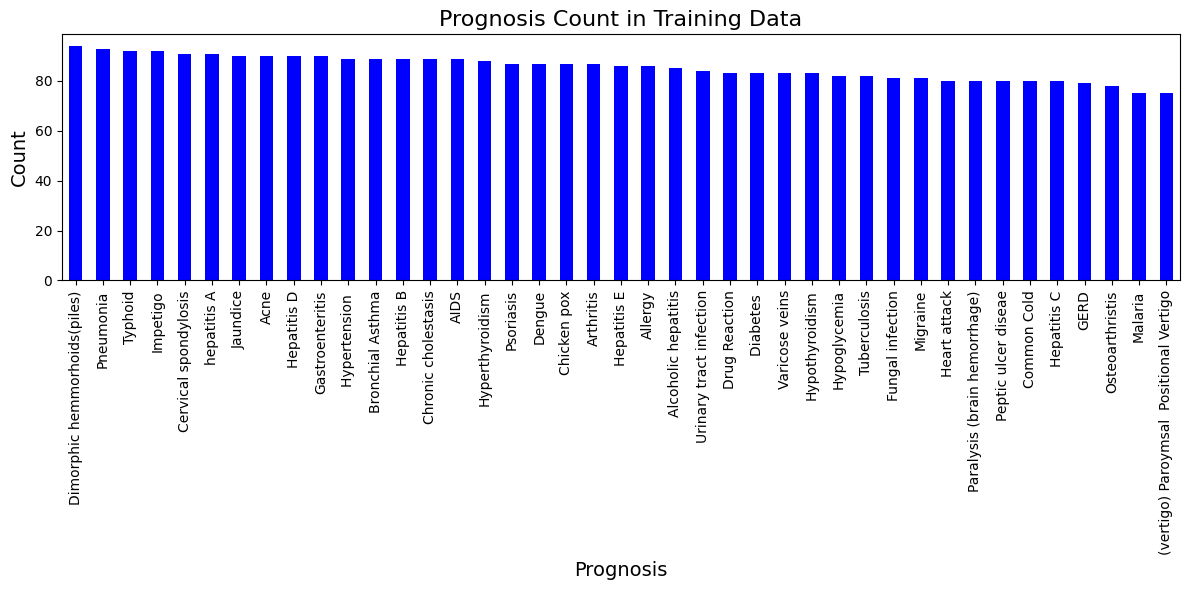

In [ ]:
# Number of rows for each prognosis in the training dataset
prognosis_count = train_df['prognosis'].value_counts()

plt.figure(figsize=(12,6))
prognosis_count.plot(kind='bar', color='blue')
plt.title('Prognosis Count in Training Data', fontsize=16)
plt.xlabel('Prognosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

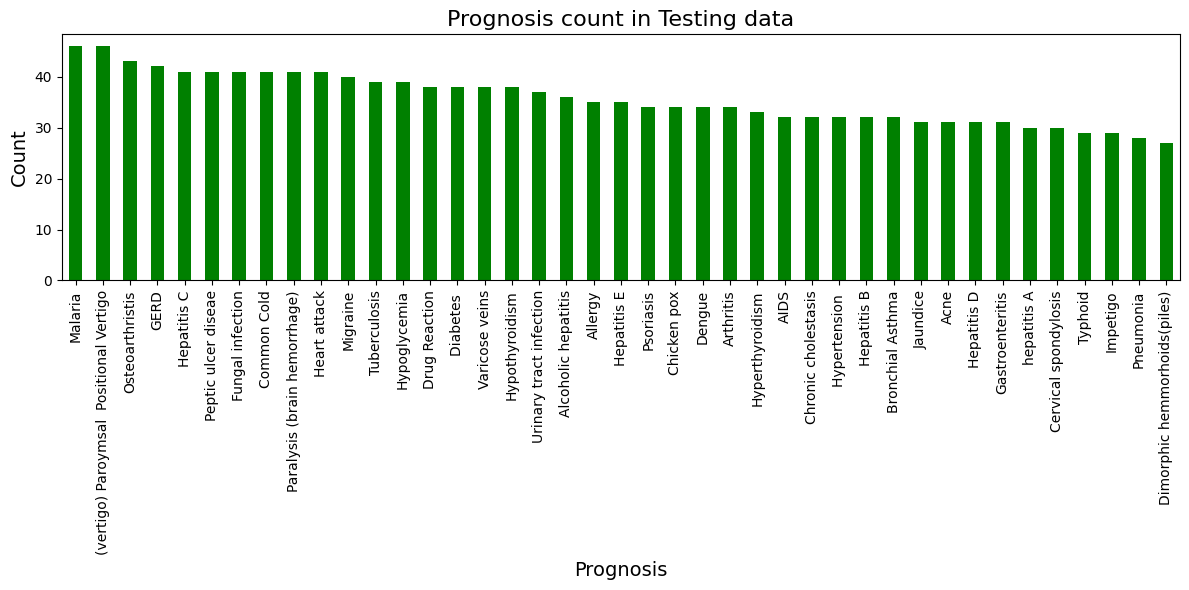

In [ ]:
# Number of rows for each prognosis in the testing dataset
prognosis_count = test_df['prognosis'].value_counts()

plt.figure(figsize=(12,6))
prognosis_count.plot(kind='bar', color='green')
plt.title('Prognosis count in Testing data', fontsize=16)
plt.xlabel('Prognosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

As we can see, after splitting our data in a 70:30 ratio, there are atleast 25 rows for each prognosis in our testing data. This will allow us to evaluate our model performance even better.

We will now encode our 41 diseases as labels (integers from 0 to 40)

In [ ]:
# Encoding the labels
def encode_labels(column):
    unique_labels = column.unqiue()
    labels = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_column = column.map(labels)
    return encoded_column, labels

In [ ]:
label_encoder = LabelEncoder()
train_df['prognosis'] = label_encoder.fit_transform(train_df['prognosis'])
test_df['prognosis'] = label_encoder.transform(test_df['prognosis'])

<ipython-input-14-775fe0e94137>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['prognosis'] = label_encoder.fit_transform(train_df['prognosis'])
<ipython-input-14-775fe0e94137>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prognosis'] = label_encoder.transform(test_df['prognosis'])


In the cell below, we drop the prognosis column from the feature data, and keep the labels in the y_train and y_Test data.

In [ ]:
X_train = train_df.drop(columns=['prognosis']).values
y_train = train_df['prognosis'].values

X_test = test_df.drop(columns=['prognosis']).values
y_test = test_df['prognosis'].values

We standardized both the training and testing data to have a mean of 0 and standard deviation of 1, to ensure that the differences in scale do not influence the results.

In [ ]:
# Standardizing training and testing datasets
epsilon = 1e-8
X_train = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0) + epsilon)
X_test = (X_test - X_test.min(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0) + epsilon)

In [ ]:
# Dataloader
def create_dataloader(features, labels, batch_size=32, shuffle=False):
    dataset = torch.utils.data.TensorDataset(torch.tensor(features, dtype=torch.float32),
                                             torch.tensor(labels, dtype=torch.long))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

We used Cross Entropy Loss as our loss function, since this is a classsification problem.

In [ ]:
# Setting the loss function
criterion = nn.CrossEntropyLoss()

We set a batch size of 32 for both the training and testing data. Additionally, we shuffled the training data to ensure that the order of the training data does not affect the training outcomes.

In [ ]:
train_loader = create_dataloader(X_train, y_train, batch_size=32, shuffle=True)
test_loader = create_dataloader(X_test, y_test, batch_size=32, shuffle=False)

The following code helps us to train the model over a specified number of epochs. We moved the features and labels to GPU to perform the training. This function returns 3 main values: accuracy, training losses and testing losses.

In [ ]:
# Training the model
def train(model, train_loader, test_loader, optimizer, device, epochs=20):
    model = model.to(device)

    model.train()
    train_losses = []
    test_losses = []
    accuracy_list = []

    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epochs%5 == 0:
          train_loss = total_loss / len(train_loader)
          train_losses.append(train_loss)
          print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

        # Testing
        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        if epochs%5 == 0:
          accuracy = correct / total
          accuracy_list.append(accuracy)
          total_test_loss = test_loss / len(test_loader)
          test_losses.append(test_loss)
          print(f"Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}")



    return accuracy, train_losses, test_losses, accuracy_list

# **MLP MODEL 1:**
We started with a baseline model, where we used 2 hidden layers, one having 16 neurons and the other having 8 neurons. Both the layers had a dropout layer of 0.5 added after it.

In [ ]:
# Defining the model
def MLP_model(input_shape, output_shape):
    model = nn.Sequential(nn.Linear(input_shape, 16),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(16,8),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(8, output_shape)

    )
    return model

In [ ]:
input_shape = X_train.shape[1]
output_shape = len(np.unique(y_train))
model = MLP_model(input_shape, output_shape)

We verified whether the model would be trained on a GPU or a CPU.
We used Adam as the optimizer function to train the weights. We used a learning rate of 0.0015 and weight decay rate of 0.001. Using higher learning rates was leading to overfitting.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=0.001)

Using device: cuda


We finally run the model over 300 epochs

In [ ]:
accuracy, train_losses, test_losses, accuracy_list = train(model, train_loader, test_loader, optimizer, device, epochs=300)

Epoch 1/300, Loss: 3.6601
Accuracy: 0.1518, Test Loss: 160.3776
Epoch 2/300, Loss: 2.8934
Accuracy: 0.3762, Test Loss: 102.3950
Epoch 3/300, Loss: 1.5622
Accuracy: 0.9083, Test Loss: 47.2698
Epoch 4/300, Loss: 0.6717
Accuracy: 0.9460, Test Loss: 19.6024
Epoch 5/300, Loss: 0.2774
Accuracy: 0.9986, Test Loss: 8.0600
Epoch 6/300, Loss: 0.1190
Accuracy: 1.0000, Test Loss: 3.7704
Epoch 7/300, Loss: 0.0653
Accuracy: 1.0000, Test Loss: 2.4249
Epoch 8/300, Loss: 0.0458
Accuracy: 1.0000, Test Loss: 1.8204
Epoch 9/300, Loss: 0.0360
Accuracy: 1.0000, Test Loss: 1.4843
Epoch 10/300, Loss: 0.0306
Accuracy: 1.0000, Test Loss: 1.3004
Epoch 11/300, Loss: 0.0270
Accuracy: 1.0000, Test Loss: 1.1890
Epoch 12/300, Loss: 0.0247
Accuracy: 1.0000, Test Loss: 1.0789
Epoch 13/300, Loss: 0.0231
Accuracy: 1.0000, Test Loss: 1.0497
Epoch 14/300, Loss: 0.0218
Accuracy: 1.0000, Test Loss: 0.9859
Epoch 15/300, Loss: 0.0209
Accuracy: 1.0000, Test Loss: 0.9379
Epoch 16/300, Loss: 0.0202
Accuracy: 1.0000, Test Loss: 0.

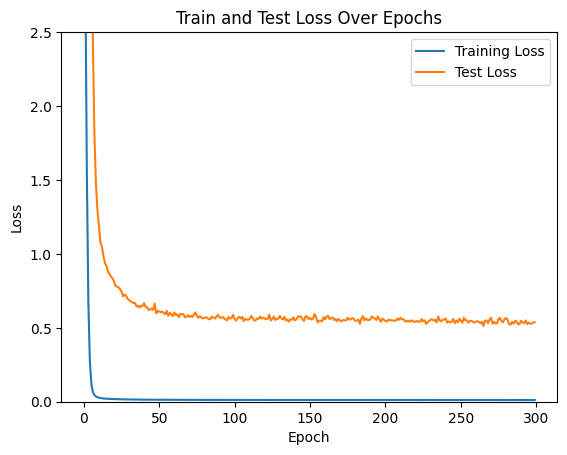

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.ylim(0,2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

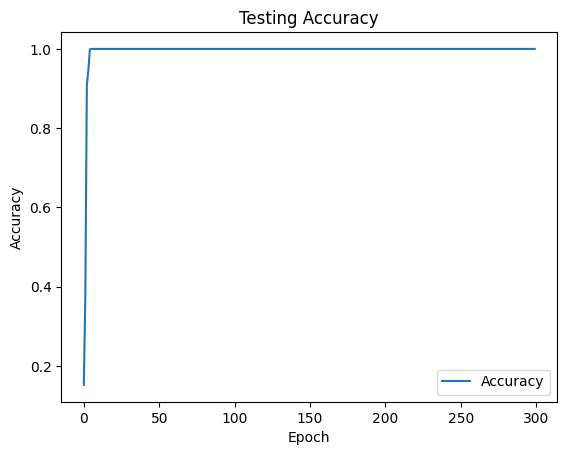

In [ ]:
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.legend()
plt.show()

We achieved a decent Mean Square Error Loss of 0.5372, while achieving a perfect test accuracy of 100%.

# **MLP MODEL 2:**
We used a more complex model this time, with 3 hidden layers, each having 64, 16 and 8 neurons respectively. We also used different dropout layers after each hidden layer (0.2, 0.3 and 0.3 respectively). We kept the learning rate and weight decay rate same as earlier, and trained the model on 200 epochs this time.

In [ ]:
def MLP_model(input_shape, output_shape):
    model1 = nn.Sequential(nn.Linear(input_shape, 64),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(64,16),
                         nn.ReLU(),
                         nn.Dropout(0.3),
                         nn.Linear(16,8),
                         nn.ReLU(),
                         nn.Dropout(0.3),
                         nn.Linear(8, output_shape)

    )
    return model1


input_shape = X_train.shape[1]
output_shape = len(np.unique(y_train))
model1 = MLP_model(input_shape, output_shape)


model1 = model1.to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.0015, weight_decay=0.001)
accuracy, train_losses, test_losses, accuracy_list = train(model1, train_loader, test_loader, optimizer, device, epochs=200)

Epoch 1/200, Loss: 3.5966
Accuracy: 0.1758, Test Loss: 143.8197
Epoch 2/200, Loss: 1.8392
Accuracy: 0.9090, Test Loss: 33.7127
Epoch 3/200, Loss: 0.3384
Accuracy: 0.9993, Test Loss: 6.0111
Epoch 4/200, Loss: 0.0790
Accuracy: 0.9993, Test Loss: 2.4673
Epoch 5/200, Loss: 0.0407
Accuracy: 1.0000, Test Loss: 1.5130
Epoch 6/200, Loss: 0.0289
Accuracy: 1.0000, Test Loss: 1.1705
Epoch 7/200, Loss: 0.0235
Accuracy: 1.0000, Test Loss: 0.9979
Epoch 8/200, Loss: 0.0210
Accuracy: 1.0000, Test Loss: 0.9224
Epoch 9/200, Loss: 0.0186
Accuracy: 1.0000, Test Loss: 0.8237
Epoch 10/200, Loss: 0.0160
Accuracy: 1.0000, Test Loss: 0.7526
Epoch 11/200, Loss: 0.0149
Accuracy: 1.0000, Test Loss: 0.6955
Epoch 12/200, Loss: 0.0140
Accuracy: 1.0000, Test Loss: 0.6526
Epoch 13/200, Loss: 0.0132
Accuracy: 1.0000, Test Loss: 0.5933
Epoch 14/200, Loss: 0.0127
Accuracy: 1.0000, Test Loss: 0.5778
Epoch 15/200, Loss: 0.0118
Accuracy: 1.0000, Test Loss: 0.5943
Epoch 16/200, Loss: 0.0119
Accuracy: 1.0000, Test Loss: 0.549

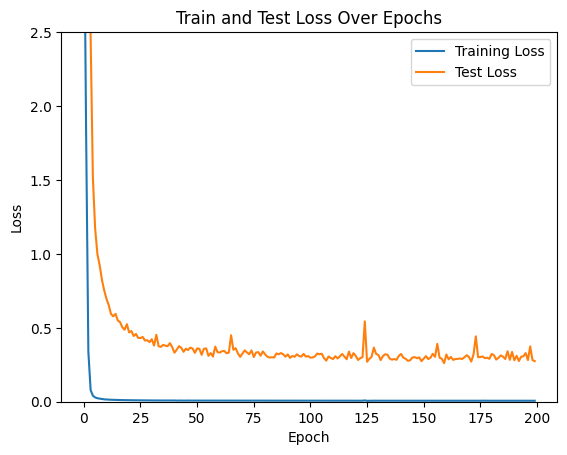

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.ylim(0,2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

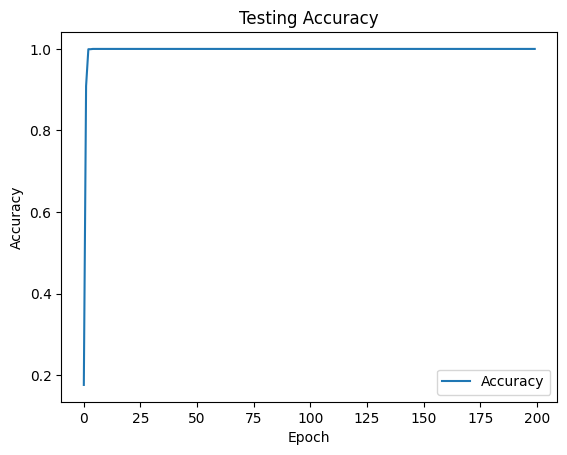

In [ ]:
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.legend()
plt.show()

As you can see, the 2nd MLP Model gives a better MSE loss of 0.2746, and fits better than the first model, while giving 100% test accuracy

We will now make a confusion matrix to see whether the predicted labels match the true labels or not.

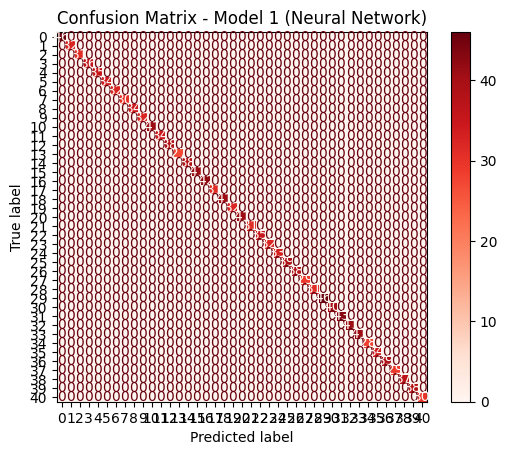

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model 1: Neural Network
# Get predictions for the test set
model.eval()
with torch.no_grad():
    y_pred_model1 = model(torch.tensor(X_test, dtype=torch.float32, device=device))
    y_pred_model1 = torch.argmax(y_pred_model1, dim=1).cpu().numpy()

# Calculating confusion matrix
cm_model1 = confusion_matrix(y_test, y_pred_model1)

# Plotting confusion matrix
disp_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1)
disp_model1.plot(cmap='Reds')
plt.title('Confusion Matrix - Model 1 (Neural Network)')
plt.show()

As shown above, all predicted labels match the true labels, with all the other entries being 0. This indicates that our model has achieved perfect prediction accuracy.

We will now compare our model performance to an existing benchmark model, which is the Logistic Regression model

In [ ]:
# Model 2: Logistic Regression
lr = LogisticRegression(multi_class = 'multinomial')
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


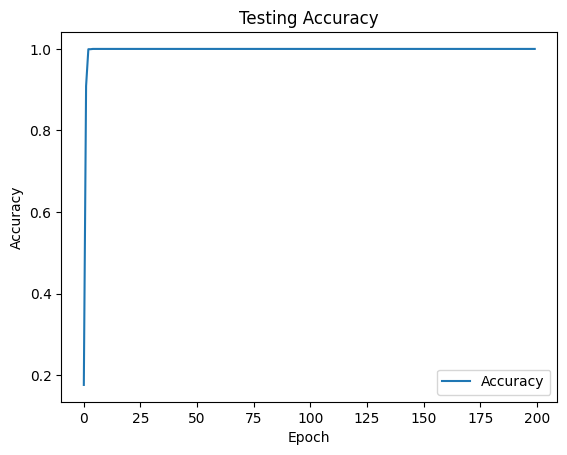

In [ ]:
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.legend()
plt.show()

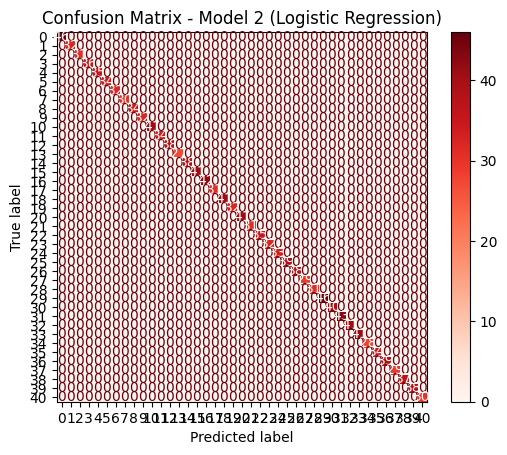

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model 2: Logistic Regression
# Calculating confusion matrix
cm_model2 = confusion_matrix(y_test, y_pred_test)

# Plotting confusion matrix
disp_model2 = ConfusionMatrixDisplay(confusion_matrix=cm_model2)
disp_model2.plot(cmap='Reds')
plt.title('Confusion Matrix - Model 2 (Logistic Regression)')
plt.show()

As we can see, both the models achieve a 100% accuracy on the testing data